In [138]:
%matplotlib inline

In [139]:
import geopandas as gpd
from dem_stitcher.geojson_io import read_geojson_gzip
import pandas as pd
from distmetrics import compute_mahalonobis_dist_2d
import matplotlib.pyplot as plt
import warnings

# Sites

In [140]:
df_sites = gpd.read_file('data/val_sites_subset.geojson')
df_sites.head()


,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,T036-076228-IW3,POINT (19.33289 4.57490)
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T108-230715-IW2,POINT (48.77698 31.75490)
2,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T101-214979-IW1,POINT (48.77698 31.75490)
3,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T014-028130-IW2,POINT (36.61178 35.52891)
4,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T021-043823-IW2,POINT (36.61178 35.52891)


In [141]:
df_sites.drop(columns=['change_time', 'last_observation_time']).explore(categorical=True, column='change_type', legend=True, marker_kwds={'radius':10})

# Bursts

In [155]:
SITE_ID = 4

In [156]:
df_site = df_sites[df_sites.site_id == SITE_ID].reset_index(drop=True)
df_site

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,T036-076228-IW3,POINT (19.33289 4.57490)


In [157]:
df_val_bursts = read_geojson_gzip('data/burst_extent_subset.geojson.gzip')
df_val_bursts.head()

,geometry,jpl_burst_id,orbit_pass
0,"POLYGON ((-97.90103 16.86358, -97.06559 17.014...",t005_008688_iw2,ASCENDING
1,"POLYGON ((-97.09889 17.06678, -96.35903 17.196...",t005_008688_iw3,ASCENDING
2,"POLYGON ((-98.69437 16.82087, -97.89903 16.966...",t005_008689_iw1,ASCENDING
3,"POLYGON ((-97.93485 17.03023, -97.09864 17.180...",t005_008689_iw2,ASCENDING
4,"POLYGON ((-97.13196 17.23328, -96.39139 17.362...",t005_008689_iw3,ASCENDING


In [158]:
df_bursts_for_site = df_val_bursts[df_val_bursts.jpl_burst_id.str.replace('_', '-').str.upper().isin(df_site.jpl_burst_id)].reset_index(drop=True)
df_bursts_for_site.head()

,geometry,jpl_burst_id,orbit_pass
0,"POLYGON ((19.82686 4.63062, 19.12143 4.78148, ...",t036_076228_iw3,DESCENDING


# Time Series

In [159]:
BURST_ID = df_bursts_for_site['jpl_burst_id'].iloc[0].replace('_', '-').upper()  # 't088_187104_iw2'.replace('_', '-').upper()

In [160]:
ts_csv = f'data/rtc_ts_by_site/rtc_summary_burst_{BURST_ID}_site{SITE_ID}.csv'
ts_csv

'data/rtc_ts_by_site/rtc_summary_burst_T036-076228-IW3_site4.csv'

In [161]:
# sample path 'data/rtc_ts_by_site/rtc_summary_burst_T088-187104-IW2_site274.csv'
df_rtc_ts_wind = pd.read_csv(ts_csv).drop(columns=['Unnamed: 0'])
df_rtc_ts_wind['datetime'] = pd.to_datetime(df_rtc_ts_wind['datetime'])
df_rtc_ts_wind.head()

,datetime,burst_id,orbit_pass_direction,site_id,site_lon,site_lat,site_x,site_y,vv,vh,vv/vh
0,2020-10-06 04:24:02,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.1010330319404602, 0.1280166506767273, 0.092...","[0.03221437335014343, 0.05000315606594086, 0.0...","[3.1362719535827637, 2.560171365737915, 3.5481..."
1,2020-10-12 04:24:42,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.20514193177223206, 0.16784778237342834, 0.0...","[0.04347224161028862, 0.04779462516307831, 0.0...","[4.7189178466796875, 3.511854887008667, 2.0983..."
2,2020-10-18 04:24:02,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.07881812751293182, 0.14559178054332733, 0.0...","[0.05312468484044075, 0.02409065142273903, 0.0...","[1.4836441278457642, 6.043497085571289, 2.0693..."
3,2020-10-24 04:24:42,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.17700569331645966, 0.1056765466928482, 0.12...","[0.030119437724351883, 0.060746751725673676, 0...","[5.876792907714844, 1.7396246194839478, 2.3721..."
4,2020-10-30 04:24:02,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.1675480753183365, 0.09752660989761353, 0.32...","[0.02593366988003254, 0.05142713338136673, 0.0...","[6.460638999938965, 1.8964037895202637, 7.8379..."


In [162]:
import ast
# Function to convert string
def convert_to_list(v):
    if isinstance(v, str):
        return ast.literal_eval(v)
    return v

In [166]:
# Convert srting to list
df_rtc_ts_wind['vv_l'] = df_rtc_ts_wind['vv'].apply(convert_to_list)
df_rtc_ts_wind['vh_l'] = df_rtc_ts_wind['vh'].apply(convert_to_list)
df_rtc_ts_wind['vv/vh_l'] = df_rtc_ts_wind['vv/vh'].apply(convert_to_list)

# get average value for window
df_rtc_ts_wind['vv_avg'] = df_rtc_ts_wind['vv_l'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)#.rolling(3).sum()
df_rtc_ts_wind['vh_avg'] = df_rtc_ts_wind['vh_l'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)#.rolling(3).sum()
df_rtc_ts_wind['vv/vh_avg'] = df_rtc_ts_wind['vv/vh_l'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)
df_rtc_ts_wind.head()

,datetime,burst_id,orbit_pass_direction,site_id,site_lon,site_lat,site_x,site_y,vv,vh,vv/vh,vv_l,vh_l,vv/vh_l,vv_avg,vh_avg,vv/vh_avg
0,2020-10-06 04:24:02,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.1010330319404602, 0.1280166506767273, 0.092...","[0.03221437335014343, 0.05000315606594086, 0.0...","[3.1362719535827637, 2.560171365737915, 3.5481...","[0.1010330319404602, 0.1280166506767273, 0.092...","[0.03221437335014343, 0.05000315606594086, 0.0...","[3.1362719535827637, 2.560171365737915, 3.5481...",0.112826,0.031784,3.598496
1,2020-10-12 04:24:42,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.20514193177223206, 0.16784778237342834, 0.0...","[0.04347224161028862, 0.04779462516307831, 0.0...","[4.7189178466796875, 3.511854887008667, 2.0983...","[0.20514193177223206, 0.16784778237342834, 0.0...","[0.04347224161028862, 0.04779462516307831, 0.0...","[4.7189178466796875, 3.511854887008667, 2.0983...",0.140844,0.042313,3.468522
2,2020-10-18 04:24:02,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.07881812751293182, 0.14559178054332733, 0.0...","[0.05312468484044075, 0.02409065142273903, 0.0...","[1.4836441278457642, 6.043497085571289, 2.0693...","[0.07881812751293182, 0.14559178054332733, 0.0...","[0.05312468484044075, 0.02409065142273903, 0.0...","[1.4836441278457642, 6.043497085571289, 2.0693...",0.106682,0.041293,2.821410
3,2020-10-24 04:24:42,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.17700569331645966, 0.1056765466928482, 0.12...","[0.030119437724351883, 0.060746751725673676, 0...","[5.876792907714844, 1.7396246194839478, 2.3721...","[0.17700569331645966, 0.1056765466928482, 0.12...","[0.030119437724351883, 0.060746751725673676, 0...","[5.876792907714844, 1.7396246194839478, 2.3721...",0.115256,0.045194,2.765992
4,2020-10-30 04:24:02,T036-076228-IW3,descending,4,19.332894,19.332894,315054.04602,505889.648256,"[0.1675480753183365, 0.09752660989761353, 0.32...","[0.02593366988003254, 0.05142713338136673, 0.0...","[6.460638999938965, 1.8964037895202637, 7.8379...","[0.1675480753183365, 0.09752660989761353, 0.32...","[0.02593366988003254, 0.05142713338136673, 0.0...","[6.460638999938965, 1.8964037895202637, 7.8379...",0.154245,0.038018,4.525134


In [167]:
POL_RATIO_PLOT = False

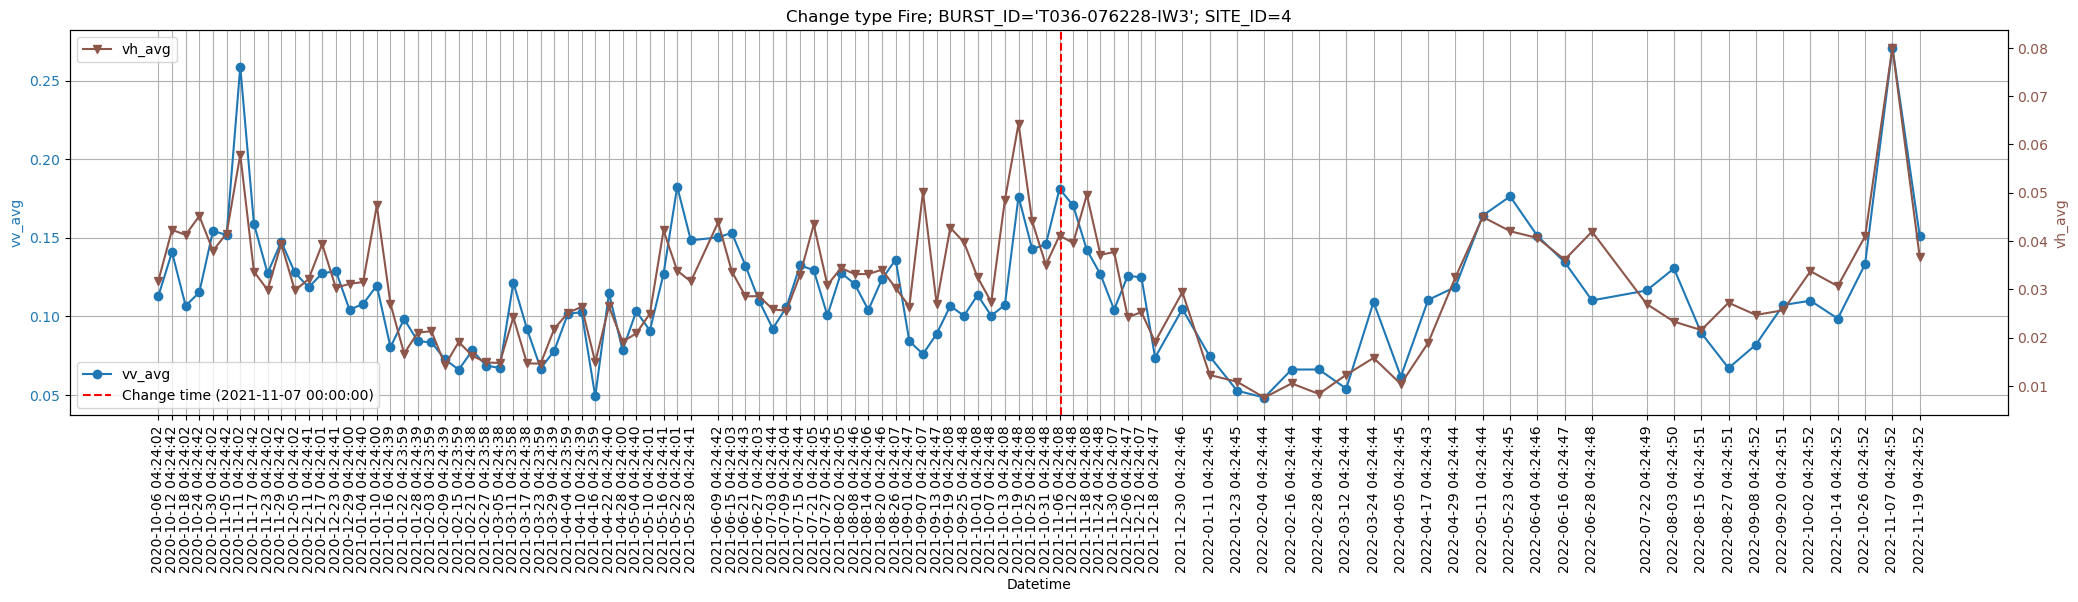

In [168]:


fig, ax1 = plt.subplots(figsize=(25, 5))
ax1.plot(df_rtc_ts_wind['datetime'], df_rtc_ts_wind['vv_avg'], marker='o', color='tab:blue', label='vv_avg')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('vv_avg', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(df_rtc_ts_wind['datetime'], df_rtc_ts_wind['vh_avg'], marker='v', color='tab:brown', label='vh_avg')
ax2.set_ylabel('vh_avg', color='tab:brown')
ax2.tick_params(axis='y', labelcolor='tab:brown')
if POL_RATIO_PLOT:
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  
    ax3.plot(df_rtc_ts_wind['datetime'], df_rtc_ts_wind['vv/vh_avg'], marker='P', color='tab:purple', label='vv/vh_avg')
    ax3.set_ylabel('vv/vh_avg', color='tab:purple')
    ax3.tick_params(axis='y', labelcolor='tab:purple')

change_type = df_site.change_type.iloc[0]
plt.title(f'Change type {change_type}; {BURST_ID=}; {SITE_ID=}')
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    ax1.set_xticks(df_rtc_ts_wind['datetime'].tolist())
    ax1.set_xticklabels(df_rtc_ts_wind['datetime'].tolist(), rotation=90)

ax1.grid(True)

last_observed_time = df_site['last_observation_time'][0]

if last_observed_time == pd.NaT:
    ax1.axvline(x=last_observed_time, color='b', linestyle='--', label=f'Last observation time ({last_observed_time})')
ax2.legend(loc='upper left')

change_time = df_site['change_time'][0]
ax1.axvline(x=change_time, color='r', linestyle='--', label=f'Change time ({change_time})')
ax1.legend()
plt.show()

- Change "accuracy" - take 1 - if first changed observation occurs after "last_observation_time" and within 1 acquisition after "change_time" then that is "perfect" accuracy.
- Change "accuracy" - take 2 - relaxed - if first changed observation occurs after last observation time or within a set time frame that is user defined.


In [153]:
# df_site.drop(columns=['change_time', 'last_observation_time']).explore(categorical=True, column='change_type', legend=True, marker_kwds={'radius':10})

# Mahalanobis Distance

TODOS:

1. standardize jpl burst id throughout data
2. for sites - get all - and have metadata tag for which are used
3. for validation bursts - nice to have counts of RTC data available
4. Missing Sites
5. Metrics
   - Mahalanobis Distance
   - Z-score for VH polarization (vegetation)
   - DB difference between post and mean (or median) of pre
6. Generate Sample Workflow for computing accuracies

In [169]:
#compute_mahalonobis_dist_2d()